# Задание

**Цель:** изучить применение дерева решений в рамках задачи регрессии

**Описание задания:**

В домашнем задании нужно решить задачу регрессии. В качестве датасета необходимо взять данные о недвижимости Калифорнии из библиотеки sklearn.datasets. Целевая переменная – MedHouseVal. Прочитать информацию о признаках датасета можно, выполнив следующий код – print(fetch_california_housing().DESCR). На полученных данных построить модель регрессии и дерево решений.

In [1]:
#!pip install reverse_geocoder
#!pip install folium
#!pip install geopy

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error

from geopy.distance import geodesic as GD
import reverse_geocoder as revgc
import warnings
warnings.filterwarnings("ignore")

# 1. Получите данные и загрузите их в рабочую среду. (Jupyter Notebook или другую).

In [3]:
df = fetch_california_housing(as_frame=True).frame
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [4]:
print(fetch_california_housing().DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

# 2. Проведите первичный анализ.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [6]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


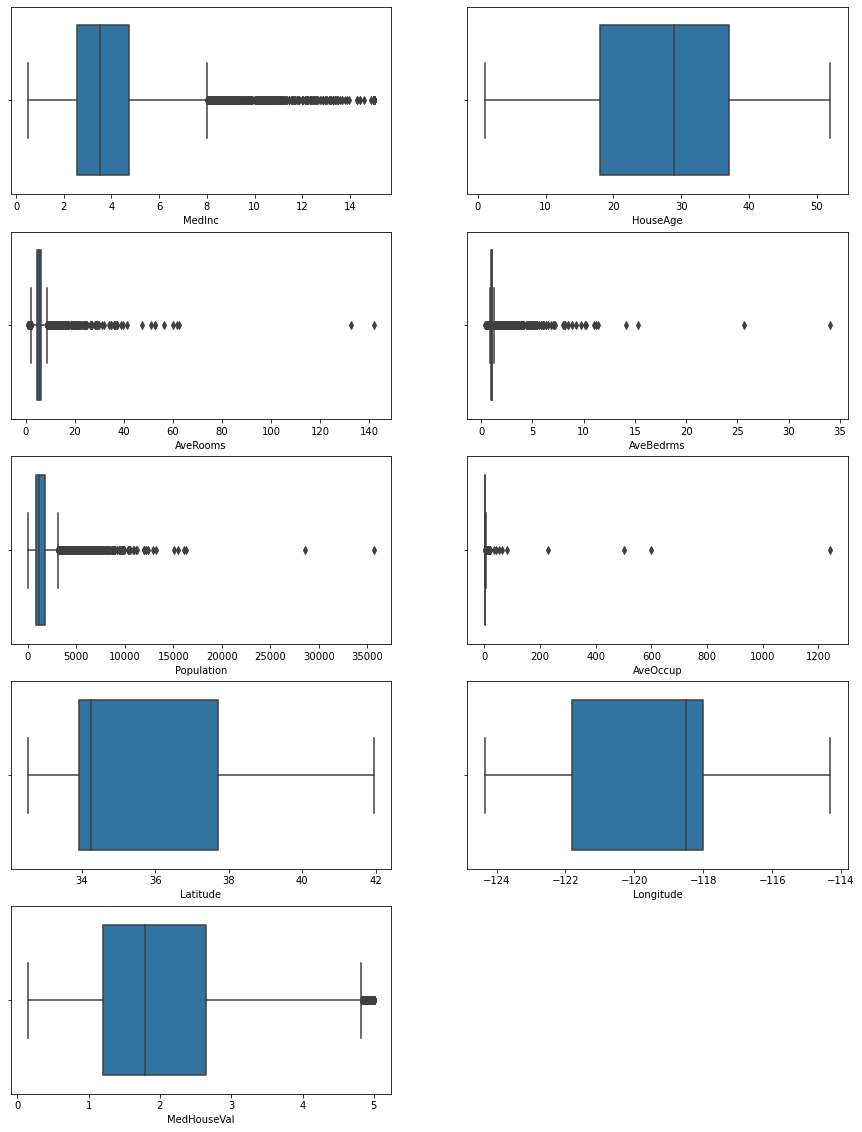

In [7]:
plt.figure(figsize=[15,20])

for col, i in zip(df.columns, range(len(df.columns))):
    plt.subplot(5, 2, i+1)
    sns.boxplot(df[col])

Столбцы AveRooms, AveBedrms, Population, AveOccup имеют ярко выраженные выбросы. Удалим их.

In [8]:
df = df.drop(index=df[(df['AveRooms'] > 45) | (df['Population'] > 15000) | (df['AveOccup'] > 200) | (df['AveBedrms'] > 8)].index)
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20614 entries, 0 to 20613
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20614 non-null  float64
 1   HouseAge     20614 non-null  float64
 2   AveRooms     20614 non-null  float64
 3   AveBedrms    20614 non-null  float64
 4   Population   20614 non-null  float64
 5   AveOccup     20614 non-null  float64
 6   Latitude     20614 non-null  float64
 7   Longitude    20614 non-null  float64
 8   MedHouseVal  20614 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


<AxesSubplot:>

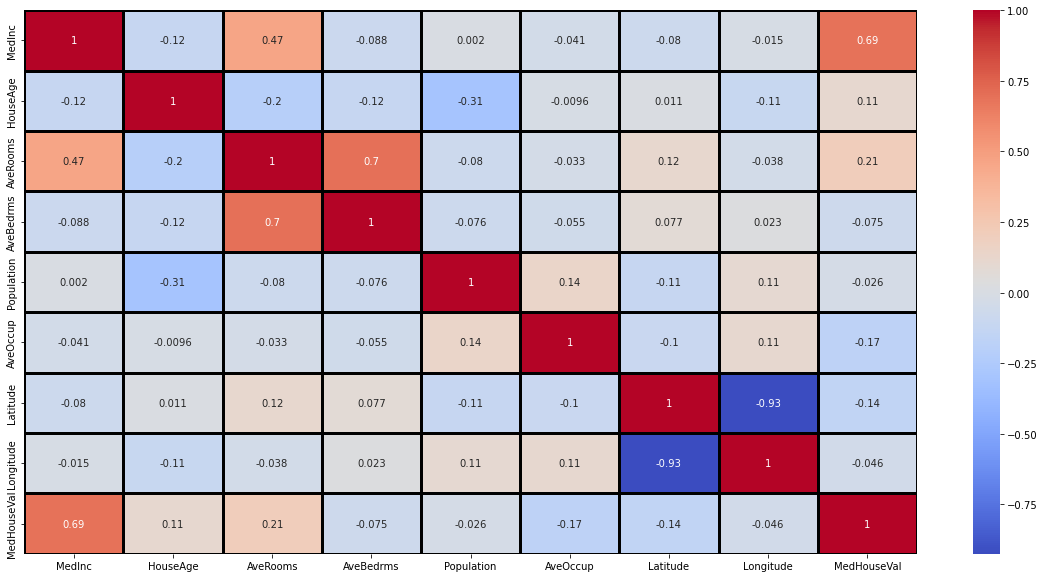

In [9]:
plt.figure(figsize=[20,10])
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=3, linecolor='black')

Целевая переменная имеет среднюю корреляцию с медианным доходом домохозяйства.

### a.Проверьте данные на пропуски. Удалите в случае обнаружения.

In [10]:
df.isna().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

Пропуски в данных отсутствуют.

### b.Нормализуйте один из признаков.

In [11]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20614.000000,20614.000000,20614.000000,20614.000000,20614.000000,20614.000000,20614.000000,20614.000000,20614.000000
mean,3.870628,28.648443,5.387359,1.087610,1419.819928,2.946672,35.629623,-119.569604,2.068768
std,1.899499,12.582753,1.782087,0.286411,1070.257719,1.221866,2.134884,2.003875,1.153925
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563925,18.000000,4.439719,1.006002,788.000000,2.430380,33.930000,-121.800000,1.197000
50%,3.534800,29.000000,5.227206,1.048695,1166.000000,2.818463,34.255000,-118.490000,1.797500
75%,4.742600,37.000000,6.048773,1.099357,1724.000000,3.282249,37.710000,-118.010000,2.648750
max,15.000100,52.000000,39.755906,7.968750,13251.000000,83.171429,41.950000,-114.310000,5.000010


Нормализуем признак Population, т.к. он имеет наибольшее среднеквадратическое отклонение.

In [12]:
df['Population'] = df['Population']/df['Population'].max()
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20614.000000,20614.000000,20614.000000,20614.000000,20614.000000,20614.000000,20614.000000,20614.000000,20614.000000
mean,3.870628,28.648443,5.387359,1.087610,0.107148,2.946672,35.629623,-119.569604,2.068768
std,1.899499,12.582753,1.782087,0.286411,0.080768,1.221866,2.134884,2.003875,1.153925
min,0.499900,1.000000,0.846154,0.333333,0.000226,0.692308,32.540000,-124.350000,0.149990
25%,2.563925,18.000000,4.439719,1.006002,0.059467,2.430380,33.930000,-121.800000,1.197000
50%,3.534800,29.000000,5.227206,1.048695,0.087993,2.818463,34.255000,-118.490000,1.797500
75%,4.742600,37.000000,6.048773,1.099357,0.130103,3.282249,37.710000,-118.010000,2.648750
max,15.000100,52.000000,39.755906,7.968750,1.000000,83.171429,41.950000,-114.310000,5.000010


# 3. Разделите выборку на обучающее и тестовое подмножества. 80% данных оставить на обучающее множество, 20% - на тестовое.

In [13]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,0.024300,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,0.181194,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,0.037431,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,0.042110,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,0.042638,2.181467,37.85,-122.25


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# 4. Обучите [модель регрессии](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) на обучающем множестве.

In [15]:
lr = LinearRegression(n_jobs=4)
lr.fit(X_train, y_train)

LinearRegression(n_jobs=4)

# 5. Для тестового множества предскажите целевую переменную и сравните с истинным значением, посчитав точность предсказания модели. Для этого используйте встроенную функцию score.

In [16]:
score_lr = lr.score(X_test, y_test)
mae_lr = mean_absolute_error(y_test, lr.predict(X_test))
score_lr

0.643430290243175

# 6. Обучите [дерево решений](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) на обучающем множестве.

In [17]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

### a. Повторите п. 5 для полученной модели.

In [18]:
score_tree = tree_reg.score(X_test, y_test)
mae_tree = mean_absolute_error(y_test, tree_reg.predict(X_test))
score_tree

0.6334311592944033

### b. Визуализируйте часть дерева решений. Убедитесь, что график получился читабельным. Посмотрите примеры визуализации по [ссылке](https://mljar.com/blog/visualize-decision-tree/).

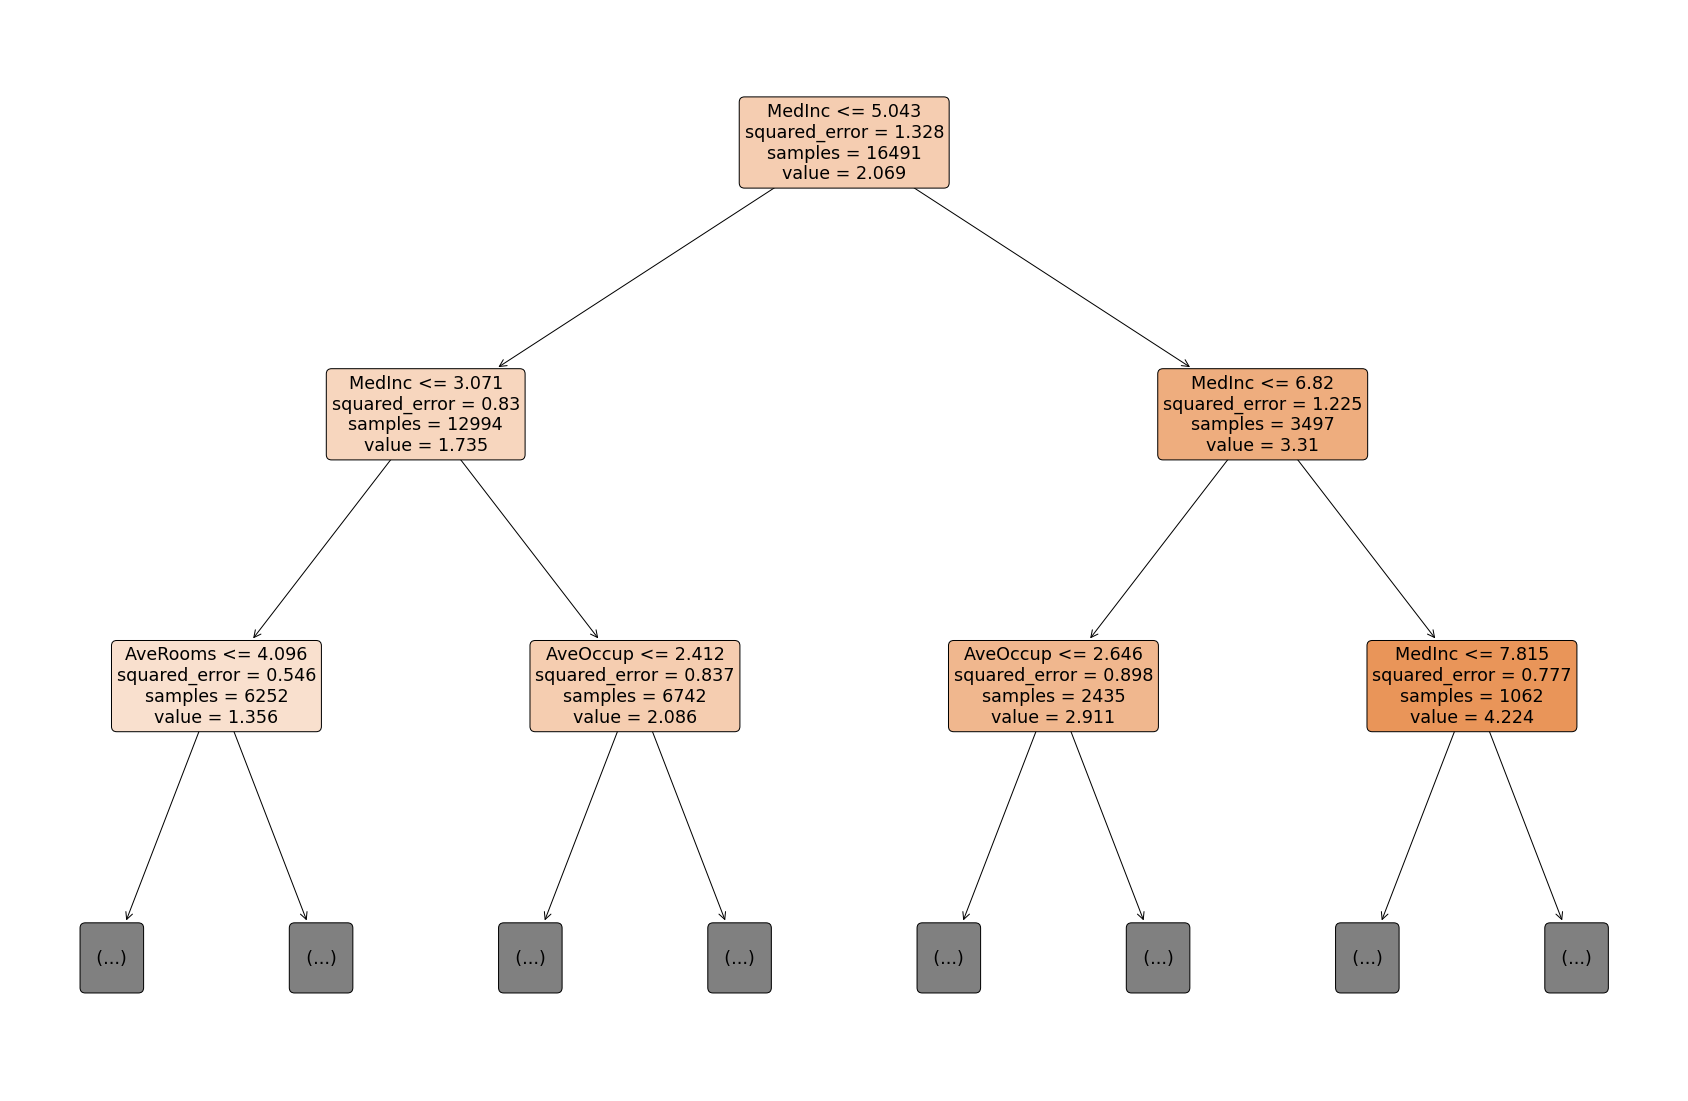

In [19]:
fig = plt.figure(figsize=(30,20))
plot_tree(tree_reg, feature_names=X_test.columns, max_depth=2, filled=True, rounded=True)
plt.show()

# 7. Оптимизируйте глубину дерева (max_depth). Оптимизируйте ещё один параметр модели на выбор.

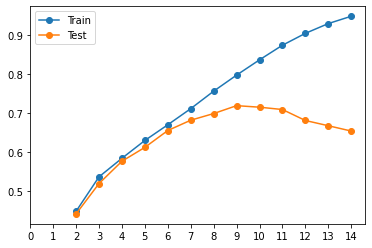

In [20]:
train = {}
test = {}

for i in range(2, 15):
    new_tree_reg = DecisionTreeRegressor(max_depth=i, random_state=42)
    new_tree_reg.fit(X_train, y_train)

    train[i] = new_tree_reg.score(X_train, y_train)
    test[i] = new_tree_reg.score(X_test, y_test)

plt.plot(train.keys(), train.values(), '-o', label='Train')
plt.plot(test.keys(), test.values(), '-o', label='Test')
plt.xticks(range(15))
plt.legend()
plt.show()

Выбираем max_depth=9.

In [21]:
depth = 9
test[depth]

0.7198908951246958

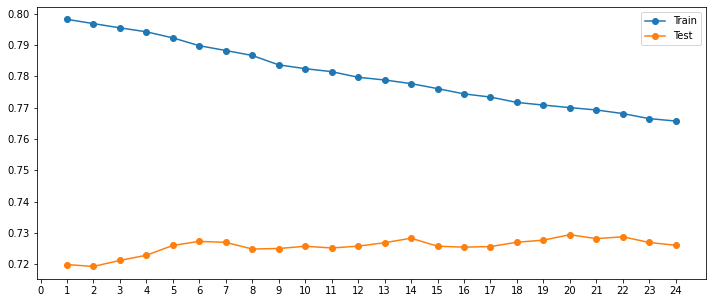

In [22]:
train = {}
test = {}

for j in range(1, 25):
    new_tree_reg = DecisionTreeRegressor(max_depth=9, min_samples_leaf=j, random_state=42)
    new_tree_reg.fit(X_train, y_train)

    train[j] = new_tree_reg.score(X_train, y_train)
    test[j] = new_tree_reg.score(X_test, y_test)

plt.figure(figsize=(12,5))
plt.plot(train.keys(), train.values(), '-o', label='Train')
plt.plot(test.keys(), test.values(), '-o', label='Test')
plt.xticks(range(25))
plt.legend()
plt.show()

Выбираем min_samples_leaf=22.

In [23]:
msl = 22
test[msl]

0.7287606519581573

In [24]:
from sklearn.model_selection import GridSearchCV

new_tree_reg = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=msl, random_state=42)
params = {'min_samples_split': range (2,10,2), 'max_features': [None, 'log2', 'sqrt']}
grid = GridSearchCV(new_tree_reg, params, n_jobs=4, cv=7)
%time grid.fit(X_test, y_test)
grid.best_params_

CPU times: total: 234 ms
Wall time: 3.38 s


{'max_features': None, 'min_samples_split': 2}

In [25]:
new_tree_reg = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=msl,
                                     min_samples_split=grid.best_params_['min_samples_split'],
                                     max_features=grid.best_params_['max_features'], random_state=42)
new_tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=9, min_samples_leaf=22, random_state=42)

### a. Повторите п. 5 для полученной модели.

In [26]:
score_tree_mod = new_tree_reg.score(X_test, y_test)
mae_tree_mod = mean_absolute_error(y_test, new_tree_reg.predict(X_test))

In [27]:
new_tree_reg.score(X_train, y_train)

0.7680794564863815

# 8. Сформулируйте выводы по проделанной работе.

### a. Сравните точность двух моделей.

In [28]:
pd.DataFrame({'Model': ['Линейная регрессия', 'Базовое дерево решений', 'Дерево решений после подбора параметров'],
             'R2': [score_lr, score_tree, score_tree_mod], 'MAE': [mae_lr, mae_tree, mae_tree_mod]})

,Model,R2,MAE
0,Линейная регрессия,0.643430,0.507071
1,Базовое дерево решений,0.633431,0.452315
2,Дерево решений после подбора параметров,0.728761,0.414593


Дерево решений с базовыми параметрами имеет немного меньший коэффициент детерминации, в сравнении с линейной регрессией, при меньшем MAE. После оптимизации параметров дерева решений метрики улучшились.

### b. Напишите свое мнение, для каких задач предпочтительнее использовать обученные в работе модели? Какие у них есть плюсы и минусы?

**Линейная регрессия** хорошо подходит для задач прогнозирования, где требуется предсказание численных значений на основе входных данных. Например, прогнозирование цен на недвижимость или спроса на продукты. Линейная регрессия хорошо работает, когда между входными и выходными данными существует линейная зависимость. Если данные демонстрируют линейные тренды или паттерны, то линейная регрессия может быть эффективным выбором.

Преимущества линейной регрессии:

- Простота и интерпретируемость модели.
- Высокая скорость обучения и предсказания.
- Может быть эффективной, когда между входными и выходными данными существует линейная зависимость.

Ограничения линейной регрессии:

- Ограниченность в моделировании сложных нелинейных взаимодействий между переменными.
- Чувствительность к выбросам и наличию гетероскедастичности в данных.

**Деревья решений** могут быть использованы для решения задач классификации, где требуется определение класса для входных данных, или для задач регрессии, где требуется прогнозирование численных значений на основе входных данных. Деревья решений могут эффективно обрабатывать категориальные признаки без необходимости их предварительного преобразования, что делает их удобными для работы с данными разного типа.

Преимущества деревьев решений:

- Способность моделировать сложные нелинейные взаимодействия между переменными.
- Более высокая интерпретируемость по сравнению с некоторыми другими моделями машинного обучения, такими как нейронные сети.
- Может эффективно обрабатывать категориальные признаки.

Ограничения деревьев решений:

- Склонность к переобучению, особенно при использовании глубоких деревьев.
- Могут быть нестабильными и чувствительными к малым изменениям в данных.
- Ограниченная способность в моделировании данных с высокой размерностью или большим количеством категориальных признаков.